In [1]:
import pandas as pd
import numpy as np
import re
import gensim

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

import multiprocessing as mp
from spellchecker import SpellChecker

import torch
import torch.nn as nn

In [2]:
if not nltk.find('corpora/wordnet'):
     nltk.download('wordnet')
porter_stemmer  = PorterStemmer()
lemmatizer      = WordNetLemmatizer()
regex_tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
spell  = SpellChecker()
one_hot_vectorizer = CountVectorizer(binary=True)

## Functions

In [34]:
def clean_text(text):
    txt = ''
    for word in text.split(" "):
        # The EE is short hand on employee
        if word=='ee' or word == 'EE':
            txt += ' employee '
        else:
            txt = txt + ' ' + word.lower().strip() + ' '
#     txt = ' '.join(word.lower() for word in text.split(" ") word = 'employee' if word=='ee')
    txt = txt.strip()
    txt = re.sub(r"([.,!?])", r" \1 ", txt)
    txt = re.sub(r"[^a-zA-Z.,!?]+", r" ", txt)
    return txt.strip()

def tokenize(text):
    return nltk.word_tokenize(text)

def stem(words, df=False):
    stemmed_words=[porter_stemmer.stem(word) for word in words]
    if df:
        return pd.DataFrame({'original': words,'stemmed': stemmed_words})
    return stemmed_words

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return None

def lemmatize(words, df=False):
    lemmatized_words=[]
    tagged_sent = nltk.pos_tag(words)
    
    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or nltk.corpus.wordnet.NOUN
        if wordnet_pos is None:
            lemmatized_words.append(lemmatizer.lemmatize(tag[0]))
        else:
            lemmatized_words.append(lemmatizer.lemmatize(tag[0], pos=wordnet_pos))
    
    if df:
        return pd.DataFrame({'original': words,'lemmatized': lemmatized_words})
    return lemmatized_words

def SK_TFIDF_stopwords(corpus, vectorizer):
    vectorizer.fit(corpus)
    X = vectorizer.transform(corpus)
    return vectorizer.stop_words_, X

def get_words(texts):
    words = []
    for text in texts:
        words+=regex_tokenizer.tokenize(text)
    return np.asarray(words).reshape(-1, 1)

def OHE(sent):
    enc = OneHotEncoder(handle_unknown='ignore')
    words=[]
    for w in sent.values:
        words += w
    X = enc.fit(np.array(words).reshape(-1,1))
    return sent.apply(lambda x: enc.transform(np.array(x).reshape(-1,1))), X.n_features_in_
    
def spell_check(words):
    return [spell.correction(word) for word in words]

def remove_stopwords(words, stopwords):
    return [w for w in words if w not in stopwords]

# Clean Narrative

In [4]:
df = pd.read_csv('us_data_2000.csv')
pd.options.display.max_columns = None
df.head(1)

,MINE_ID,CONTROLLER_ID,CONTROLLER_NAME,OPERATOR_ID,OPERATOR_NAME,CONTRACTOR_ID,DOCUMENT_NO,SUBUNIT_CD,SUBUNIT,ACCIDENT_DT,CAL_YR,CAL_QTR,FISCAL_YR,FISCAL_QTR,ACCIDENT_TIME,DEGREE_INJURY_CD,DEGREE_INJURY,FIPS_STATE_CD,UG_LOCATION_CD,UG_LOCATION,UG_MINING_METHOD_CD,UG_MINING_METHOD,MINING_EQUIP_CD,MINING_EQUIP,EQUIP_MFR_CD,EQUIP_MFR_NAME,EQUIP_MODEL_NO,SHIFT_BEGIN_TIME,CLASSIFICATION_CD,CLASSIFICATION,ACCIDENT_TYPE_CD,ACCIDENT_TYPE,NO_INJURIES,TOT_EXPER,MINE_EXPER,JOB_EXPER,OCCUPATION_CD,OCCUPATION,ACTIVITY_CD,ACTIVITY,INJURY_SOURCE_CD,INJURY_SOURCE,NATURE_INJURY_CD,NATURE_INJURY,INJ_BODY_PART_CD,INJ_BODY_PART,SCHEDULE_CHARGE,DAYS_RESTRICT,DAYS_LOST,TRANS_TERM,RETURN_TO_WORK_DT,IMMED_NOTIFY_CD,IMMED_NOTIFY,INVEST_BEGIN_DT,NARRATIVE,CLOSED_DOC_NO,COAL_METAL_IND
0,100003,41044,Lhoist Group,L13586,Lhoist North America,NaN,2.201210e+11,3,"STRIP, QUARY, OPEN PIT",14/03/2012,2012,1,2012,2,945,5,DAYS RESTRICTED ACTIVITY ONLY,1,?,NO VALUE FOUND,?,NO VALUE FOUND,24,"Front-end loader, Tractor-shovel, Payloader, H...",119,Not on this list,22321,600.0,12,POWERED HAULAGE,21,"CGHT I, U, B, MVNG & STTN OBJS",1,4.35,4.35,0.67,374,"Warehouseman, Bagger, Palletizer/Stacker, Stor...",28,HANDLING SUPPLIES/MATERIALS,76,SURFACE MINING MACHINES,160,"CONTUSN,BRUISE,INTAC SKIN",700,MULTIPLE PARTS (MORE THAN ONE MAJOR),0.0,8.0,0.0,N,03/26/2012,?,NO VALUE FOUND,NaN,Employee was cleaning up at the Primary Crushe...,NaN,M


In [5]:
pd.options.display.max_columns = 20
df = df[['DEGREE_INJURY', 'DEGREE_INJURY_CD','NATURE_INJURY', 'INJ_BODY_PART', 'ACTIVITY', 'INJURY_SOURCE', 'NARRATIVE']]
df.head(1)

,DEGREE_INJURY,DEGREE_INJURY_CD,NATURE_INJURY,INJ_BODY_PART,ACTIVITY,INJURY_SOURCE,NARRATIVE
0,DAYS RESTRICTED ACTIVITY ONLY,5,"CONTUSN,BRUISE,INTAC SKIN",MULTIPLE PARTS (MORE THAN ONE MAJOR),HANDLING SUPPLIES/MATERIALS,SURFACE MINING MACHINES,Employee was cleaning up at the Primary Crushe...


In [6]:
df.isnull().any()

DEGREE_INJURY       False
DEGREE_INJURY_CD    False
NATURE_INJURY       False
INJ_BODY_PART       False
ACTIVITY            False
INJURY_SOURCE       False
NARRATIVE           False
dtype: bool

In [7]:
print("Origin data size:      ", df.shape[0])
print('NARRATIVE NaN count:   ', df[df['NARRATIVE'].isna()].shape[0])
print('NARRATIVE len>10 count:', df[df['NARRATIVE'].str.len() < 10].shape[0])

Origin data size:       2000
NARRATIVE NaN count:    0
NARRATIVE len>10 count: 1


#### Remove Narrative are too short and NA

In [8]:
df = df[df['NARRATIVE'].notna()]
df = df[df['NARRATIVE'].str.len() > 10]
print("Clean data size:", df.shape[0])

Clean data size: 1999


### To Lower case - Narrative

In [9]:
with mp.Pool(mp.cpu_count()) as pool:
    df['NARRATIVE'] = pool.map(clean_text, df['NARRATIVE'])
df['NARRATIVE'].values[0]

'employee was cleaning up at the primary crusher with the dingo skid steer . the employee slipped and fell while operating the skid steer and the machine pinned him against the cement retaining wall .'

### lem and stem

#### Test lem and stem

In [10]:
df_stem      = stem(nltk.tokenize.word_tokenize((df['NARRATIVE'].values[0])), df=True)
df_lemmatize = lemmatize(nltk.tokenize.word_tokenize((df['NARRATIVE'].values[0])), df=True)
df_stem['lemmatized'] = df_lemmatize['lemmatized']

In [11]:
df_stem[df_stem['stemmed'] != df_stem['lemmatized']]

,original,stemmed,lemmatized
0,employee,employe,employee
1,was,wa,be
6,primary,primari,primary
15,employee,employe,employee
20,operating,oper,operate
26,machine,machin,machine


### Lemmatize and stemming words

In [12]:
# Tokenize words
with mp.Pool(mp.cpu_count()) as pool:
    df['NARRATIVE_token'] = pool.map(tokenize, df['NARRATIVE'])
print(df['NARRATIVE_token'][0])

['employee', 'was', 'cleaning', 'up', 'at', 'the', 'primary', 'crusher', 'with', 'the', 'dingo', 'skid', 'steer', '.', 'the', 'employee', 'slipped', 'and', 'fell', 'while', 'operating', 'the', 'skid', 'steer', 'and', 'the', 'machine', 'pinned', 'him', 'against', 'the', 'cement', 'retaining', 'wall', '.']


In [13]:
# Correct words
with mp.Pool(mp.cpu_count()) as pool:
    df['NARRATIVE_token'] = pool.map(spell_check, df['NARRATIVE_token'])
print(df['NARRATIVE_token'][0])

['employee', 'was', 'cleaning', 'up', 'at', 'the', 'primary', 'crusher', 'with', 'the', 'dingo', 'skid', 'steer', '.', 'the', 'employee', 'slipped', 'and', 'fell', 'while', 'operating', 'the', 'skid', 'steer', 'and', 'the', 'machine', 'pinned', 'him', 'against', 'the', 'cement', 'retaining', 'wall', '.']


In [14]:
# Lemmatizing
with mp.Pool(mp.cpu_count()) as pool:
    df['NARRATIVE_LEM'] = pool.map(lemmatize, df['NARRATIVE_token'])
print(df['NARRATIVE_LEM'][0])

['employee', 'be', 'clean', 'up', 'at', 'the', 'primary', 'crusher', 'with', 'the', 'dingo', 'skid', 'steer', '.', 'the', 'employee', 'slip', 'and', 'fell', 'while', 'operate', 'the', 'skid', 'steer', 'and', 'the', 'machine', 'pin', 'him', 'against', 'the', 'cement', 'retain', 'wall', '.']


In [15]:
# Stemming
with mp.Pool(mp.cpu_count()) as pool:
    df['NARRATIVE_STEM'] = pool.map(stem, df['NARRATIVE_token'])
print(df['NARRATIVE_STEM'][0])

['employe', 'wa', 'clean', 'up', 'at', 'the', 'primari', 'crusher', 'with', 'the', 'dingo', 'skid', 'steer', '.', 'the', 'employe', 'slip', 'and', 'fell', 'while', 'oper', 'the', 'skid', 'steer', 'and', 'the', 'machin', 'pin', 'him', 'against', 'the', 'cement', 'retain', 'wall', '.']


In [16]:
# Lemmatizing then Stemming
with mp.Pool(mp.cpu_count()) as pool:
    df['NARRATIVE_LEM_STEM'] = pool.map(lemmatize, df['NARRATIVE_LEM'])
print(df['NARRATIVE_LEM_STEM'][0])

['employee', 'be', 'clean', 'up', 'at', 'the', 'primary', 'crusher', 'with', 'the', 'dingo', 'skid', 'steer', '.', 'the', 'employee', 'slip', 'and', 'fell', 'while', 'operate', 'the', 'skid', 'steer', 'and', 'the', 'machine', 'pin', 'him', 'against', 'the', 'cement', 'retain', 'wall', '.']


# Create Stopwords

In [17]:
vectorizer = TfidfVectorizer(stop_words=['abb', 'ac', 'abc', 'bo', 'it', 'dia'], max_df=0.15, min_df=1)
stopwrods, X  = SK_TFIDF_stopwords(df.apply(lambda row: ' '.join(row['NARRATIVE_LEM_STEM']), axis=1), vectorizer)
print(len(stopwrods))

18


In [18]:
terms = vectorizer.get_feature_names()
# sum tfidf frequency of each term through documents

sums = X.sum(axis=0)

# connecting term to its sums frequency
data = []
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))

ranking = pd.DataFrame(data, columns=['term','rank'])
print('Ascending')
print(ranking.sort_values('rank', ascending=True)[0:15])

Ascending
               term      rank
2149        pinched  0.134361
2119  perpendicular  0.142193
927       elevation  0.142193
217            baby  0.147287
39      acupuncture  0.147287
3231    unknowingly  0.148739
141      applicator  0.155270
2681        silicon  0.155270
999        exercise  0.156959
2084    participate  0.156959
3125            tow  0.157430
618          consul  0.157588
1665      lightbulb  0.157588
2398          relax  0.157588
836             dog  0.157588


/home/cun/anaconda3/envs/CITS4012/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
print('Descending')
print(ranking.sort_values('rank', ascending=False)[0:15])

Descending
        term       rank
1045    fall  51.306178
1642    left  44.523253
1285    hand  44.288816
1066    fell  43.290685
1090  finger  42.824256
2728    slip  42.404891
702      cut  42.365139
2502    roof  41.552680
2492    rock  41.543241
334     bolt  39.891685
3404    work  39.028079
1976     off  38.413776
1311    have  37.090783
2859    step  35.647977
3254      up  34.777416


In [20]:
[stopwrods.add(w) for w in ['abb', 'ac', 'abc', 'bo', 'it', 'dia']]

[None, None, None, None, None, None]

In [21]:
print(stopwrods)

{'abc', 'back', 'when', 'to', 'dia', 'with', 'ac', 'cause', 'the', 'bo', 'while', 'on', 'his', 'in', 'it', 'from', 'right', 'and', 'be', 'employee', 'at', 'abb', 'of', 'he'}


In [22]:
print(df['NARRATIVE_LEM_STEM'][0])
df['text'] = df['NARRATIVE_LEM_STEM'].apply(lambda x: remove_stopwords(x, stopwrods))
print(df['text'][0])

['employee', 'be', 'clean', 'up', 'at', 'the', 'primary', 'crusher', 'with', 'the', 'dingo', 'skid', 'steer', '.', 'the', 'employee', 'slip', 'and', 'fell', 'while', 'operate', 'the', 'skid', 'steer', 'and', 'the', 'machine', 'pin', 'him', 'against', 'the', 'cement', 'retain', 'wall', '.']
['clean', 'up', 'primary', 'crusher', 'dingo', 'skid', 'steer', '.', 'slip', 'fell', 'operate', 'skid', 'steer', 'machine', 'pin', 'him', 'against', 'cement', 'retain', 'wall', '.']


# Binary Document Classification

In [23]:
data = df[['DEGREE_INJURY_CD', 'DEGREE_INJURY', 'text']].copy()

In [24]:
print('DEGREE_INJURY_CD "?" count: ', data[data['DEGREE_INJURY_CD'] == '?'].shape[0])
print('DEGREE_INJURY NaN count:   ', data[data['DEGREE_INJURY'].isna()].shape[0])

DEGREE_INJURY_CD "?" count:  11
DEGREE_INJURY NaN count:    0


In [25]:
print("Origin data size:", data.shape[0])
data = data[data['DEGREE_INJURY_CD'] != '?']
data['DEGREE_INJURY_CD'] = pd.to_numeric(data['DEGREE_INJURY_CD'])
print("Removed '?' data size:", data.shape[0])

Origin data size: 1999
Removed '?' data size: 1988


In [26]:
def get_degree_injury(dataframe):
    CD = []
    INJURY = []
    for i in range(0, len(dataframe.DEGREE_INJURY_CD.unique())):
        CD.append(i)
        INJURY.append(dataframe[dataframe['DEGREE_INJURY_CD'] == i]['DEGREE_INJURY'].values[0])
    return pd.DataFrame({'DEGREE_INJURY_CD': CD,'DEGREE_INJURY': INJURY})
get_degree_injury(data)

,DEGREE_INJURY_CD,DEGREE_INJURY
0,0,ACCIDENT ONLY
1,1,FATALITY
2,2,PERM TOT OR PERM PRTL DISABLTY
3,3,DAYS AWAY FROM WORK ONLY
4,4,DYS AWY FRM WRK & RESTRCTD ACT
5,5,DAYS RESTRICTED ACTIVITY ONLY
6,6,"NO DYS AWY FRM WRK,NO RSTR ACT"
7,7,OCCUPATNAL ILLNESS NOT DEG 1-6
8,8,INJURIES DUE TO NATURAL CAUSES
9,9,INJURIES INVOLVNG NONEMPLOYEES


In [27]:
100*data['DEGREE_INJURY'].value_counts(normalize=True)

DAYS AWAY FROM WORK ONLY          29.879276
NO DYS AWY FRM WRK,NO RSTR ACT    27.766600
DAYS RESTRICTED ACTIVITY ONLY     18.058350
ACCIDENT ONLY                     11.016097
DYS AWY FRM WRK & RESTRCTD ACT     7.293763
OCCUPATNAL ILLNESS NOT DEG 1-6     2.867203
ALL OTHER CASES (INCL 1ST AID)     1.006036
PERM TOT OR PERM PRTL DISABLTY     0.905433
FATALITY                           0.553320
INJURIES DUE TO NATURAL CAUSES     0.503018
INJURIES INVOLVNG NONEMPLOYEES     0.150905
Name: DEGREE_INJURY, dtype: float64

In [28]:
group1 = [
    'DAYS AWAY FROM WORK ONLY',
    'DAYS RESTRICTED ACTIVITY ONLY',
    'DYS AWY FRM WRK & RESTRCTD ACT'
]
data['OHE_DEGREE'] = data['DEGREE_INJURY'].isin(group1)
data["OHE_DEGREE"] = data["OHE_DEGREE"].astype(int)
del data['DEGREE_INJURY']
del data['DEGREE_INJURY_CD']

### Test one hot encoding and run

In [35]:
data['OHE'], dim = OHE(data['text'])

In [36]:
print(data['OHE'].values[0].shape)

(21, 3435)


In [37]:
dim

1

In [33]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function 1: 784 --> 100
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()

        # Linear function 2: 100 --> 100
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.relu2 = nn.ReLU()

        # Linear function 3: 100 --> 100
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.relu3 = nn.ReLU()

        # Linear function 4 (readout): 100 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)

        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.relu2(out)

        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.relu3(out)

        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

In [ ]:
input_dim = dim*dim
hidden_dim = 100
output_dim = 10

In [ ]:
dim

<AxesSubplot:>

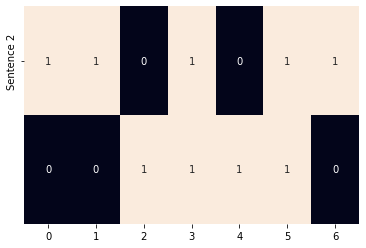

In [35]:
corpus = ['Time flies flies like an arrow.',
          'Fruit flies like a banana.']
one_hot_vectorizer = CountVectorizer(binary=True)
one_hot = one_hot_vectorizer.fit_transform(corpus).toarray()
sns.heatmap(one_hot, annot=True,cbar=False,yticklabels=['Sentence 2'])

### Split data

In [17]:
train, test = train_test_split(task1_data, test_size=0.2, random_state=42, shuffle=True, stratify=task1_data['OHE_DEGREE'])

In [18]:
print("Train size:", train.shape[0], "\nTest size: ", test.shape[0])

Train size: 161520 
Test size:  40380


# Multi-class Document Classification

# NER

# Bonus

0         employee was cleaning up at the primary crushe...
1         handle of sledgehammer broke and head of hamme...
2         employee was climbing down a ladder and when h...
3         he pulled a back muscle while stacking bags of...
4         ee hands began to break out in a rash after he...
                                ...                        
202809    ee had been working with a heavy shovel in the...
202810     hydraulic sleeve exploit causing a small explosn
202811    the accident occurred on the conveyor belt tha...
202812      uncovering valve pinched finger on right han . 
202813    while inspecting the skid loader after operati...
Name: NARRATIVE, Length: 201900, dtype: object

In [83]:
mask = (df['NARRATIVE'].str.len() < 30)
df.loc[mask]['NARRATIVE'].values

array(['shoulder strain , neck pain .', 'slipped on truck step .',
       'improper lifting techniques .', 'lifting forms for concrete',
       'fault in top .', 'pulling feeder cable',
       'pulling on belt slipped fell', 'roof fall in inactive slope .',
       'cumulative trauma', 'carpal tunnel', 'heat exhaustion'],
      dtype=object)